In [1]:
import json
import csv
import glob
import pandas as pd
import numpy as np
import os
import shutil

from PIL import Image
import matplotlib.pyplot as plt

# path = './data/data-of-baselines-v2-4-stag.json'
path = './data/data-of-baselines-v2-sarl-ddqn-empathy-peccimistic-4-stag.json'

In [2]:
#load data from the json file
with open(path) as train_file:
    data = json.load(train_file)

# Survay results:

upload Id workers and search for duplicate workers

In [3]:
raw_df_state_to_action = pd.DataFrame.from_dict(data['humanModel'], orient='index')
raw_df_state_to_action = raw_df_state_to_action.drop(0, axis=1)

participants_df = pd.DataFrame.from_dict(data['all-games'], orient='index')

workers_path = 'data/workers' # use your path
all_files = glob.glob(workers_path + "/*.csv")

li = []
for filename in all_files:
    fromOne = pd.read_csv(filename, index_col=None, header=0)
    fromOne['filename'] = filename
    li.append(fromOne)

workers = pd.concat(li, axis=0, ignore_index=True)
workers = workers.set_index('Answer.surveycode')
workers.index = workers.index.map(lambda code: '-' + code[:-3])
print(workers.index[workers.index.duplicated()])
workers = workers[~workers.index.duplicated(keep='first')]
participants_df['WorkerId'] = workers['WorkerId']
participants_df = participants_df.dropna(subset = ['WorkerId'])
participants_df.head()

Index([], dtype='object', name='Answer.surveycode')


,WorkerId,additional_comments,behavior,birth_year,collaborative_value,computer_score,computer_value,education,gender,human_score,predictable_value,selfishly_value,wisely_value,realScore
-N2gl9wHXMJoXRg5OyiP,A6Y7SZU9L301W,,follow_stag,1980,4,41,7,BA,male,46,6,1,4,NaN
-N2gnbwu9gs6PgpScg-B,A3RHJEMZ4EGY2U,,follow_stag,1994,7,24,7,BA,female,41,4,1,4,NaN
-N2gpqCiV6iClR2iJfDD,APIUR4WD44BQ1,good,follow_stag,1975,5,9,4,Master's degree,male,14,6,4,5,NaN
-N2gzRD6MoUAWRj3PaOV,AJ9IY4IHOGB8,no,follow_stag,1988,5,8,1,BA,male,9,6,6,5,NaN
-N2h6FFFrGGqFAUIRi6W,A2JPO11US5Q4H4,good,follow_stag,1988,6,0,6,BA,female,6,6,6,6,NaN


In [4]:
participants_df.columns

Index(['WorkerId', 'additional_comments', 'behavior', 'birth_year',
       'collaborative_value', 'computer_score', 'computer_value', 'education',
       'gender', 'human_score', 'predictable_value', 'selfishly_value',
       'wisely_value', 'realScore'],
      dtype='object')

In [5]:
participants_df.shape

(318, 14)

In [6]:
raw_df_state_to_action.shape

(322, 60)

In [7]:
index_to_drop = participants_df[participants_df.duplicated('WorkerId', keep='first')].index
print(len(index_to_drop))

participants_df = participants_df[~participants_df.duplicated('WorkerId', keep='first')]

25


number of people that answer the survay only once:

In [8]:
len(participants_df)

293

In [9]:
participants_df[['additional_comments', 'behavior']][participants_df['additional_comments'].notna()][participants_df['additional_comments'] != ""].tail()

,additional_comments,behavior
-N9DYxRU_2rKIQ1shGxk,Task was very interesting to perform,dropout ddqn
-N9DZPm0Emh8GJhIDPfA,Thank you good luck with your work,dropout ddqn
-N9Db1yv1762gUq8UF7t,Thank you,dropout ddqn
-N9Dgmu9C3EUcHWoteuW,Everything was fine,dropout ddqn
-N9Dn_Jyy-u60LW0vPVL,none,dropout ddqn


In [10]:
participants_df.loc[: ,'human_score'] = pd.to_numeric(participants_df['human_score'], errors='coerce')
participants_df.loc[: ,'computer_score'] = pd.to_numeric(participants_df['computer_score'], errors='coerce')
participants_df.loc[: ,'collaborative_value'] = pd.to_numeric(participants_df['collaborative_value'], errors='coerce')
participants_df.loc[: ,'predictable_value'] = pd.to_numeric(participants_df['predictable_value'], errors='coerce')
participants_df.loc[: ,'selfishly_value'] = pd.to_numeric(participants_df['selfishly_value'], errors='coerce')
participants_df.loc[: ,'wisely_value'] = pd.to_numeric(participants_df['wisely_value'], errors='coerce')
participants_df.loc[: ,'computer_value'] = pd.to_numeric(participants_df['computer_value'], errors='coerce')

In [11]:
participants_df = participants_df[participants_df.human_score > 15]

In [12]:
participants_df.groupby('behavior')[['computer_score', 'human_score', 'collaborative_value', 'predictable_value', 'selfishly_value', 'wisely_value', 'computer_value']].mean()

,computer_score,human_score,collaborative_value,predictable_value,selfishly_value,wisely_value,computer_value
behavior,,,,,,,
closest,27.075000,23.975000,3.275000,4.200000,4.725000,4.300000,5.625000
ddqn,27.846154,29.192308,4.692308,4.153846,3.153846,5.115385,4.807692
dropout ddqn,28.250000,32.750000,5.291667,4.041667,3.250000,4.541667,4.833333
empathy ddqn,30.625000,24.333333,3.083333,4.291667,5.083333,3.875000,5.583333
follow_stag,26.285714,36.833333,5.404762,4.904762,2.833333,5.023810,5.547619
random,8.020408,22.306122,3.387755,3.571429,4.244898,3.081633,5.816327
sarl ddqn,33.965517,35.310345,5.482759,4.620690,3.137931,5.103448,5.413793


In [13]:
# participants_df[['computer_score', 'human_score', 'behavior']].to_excel("data/agents_score_for_beta.xlsx")

In [14]:
participants_df['behavior'].value_counts()

random          49
follow_stag     42
closest         40
sarl ddqn       29
ddqn            26
empathy ddqn    24
dropout ddqn    24
Name: behavior, dtype: int64

In [15]:
participants_df['gender'].value_counts()

male      132
female    102
Name: gender, dtype: int64

In [16]:
participants_df['education'].value_counts()

BA                 141
High School         53
Master's degree     36
Ph.D                 4
Name: education, dtype: int64

# View some data

In [17]:
# remove from the dataset :
index_to_drop = [x for x in raw_df_state_to_action.index if x not in participants_df.index]
print(index_to_drop)

['-N2gpqCiV6iClR2iJfDD', '-N2gzRD6MoUAWRj3PaOV', '-N2h6FFFrGGqFAUIRi6W', '-N2r1MteSut6_uplAEQN', '-N2r4XA_AtRfHeu80hSd', '-N2r6pAEKaMLbxso_Nom', '-N2rHrXdpx0cHP8i9DfI', '-N2rLA_cH3GO6UJ_M4Wg', '-N3uSFmsGH9QoeLMn2Sp', '-N3uSQ6fTBht1y-rRuwO', '-N3uSv0t5MMoHiSk9mV9', '-N3uTQU7ZF1CRfwUSUNG', '-N3uXK-pqwtVt6el9Ks2', '-N3u_-wuJgMIH0lCRMuR', '-N3ubJNnx-yyc4GxXE8A', '-N3ugOCIpM6xZeVfkGnp', '-N3uhm198VZ44J_Vh6co', '-N3uhxvCsCnmNwN-PucK', '-N3xR5UfHcnRH5BS3meJ', '-N605MFTS2FjoN5Wl4nd', '-N7S7QCaT2R-cN-xQoen', '-N8z5sWrpVLWXJr0XHYp', '-N8z64UTBQrGv28-F-vT', '-N8z6BOSRhCLiVnroe_N', '-N8z6ZLBPHMZi_wmHTjL', '-N8z6mtQwG3LxOMKDwT9', '-N8z7bxUePKAtBv9Iavz', '-N8z7pDzDI_miAucjwze', '-N8z8IAcRRujJQp-YHT2', '-N8z8pVpQkohYejID0x4', '-N8z96NpWLiIKZ3Mq1ek', '-N8z98RBakx--zf4NyF3', '-N8z9nOIEyo1ZA--wrax', '-N8zAdrIR9z-IPah1x6V', '-N8zAs_feFKPTBnO4grv', '-N8zB8ZTLb5xqy0ALDGD', '-N8zBut3Q1joUv2ktwDA', '-N8zC22pvOqjzl1CrCmH', '-N8zCOt0SBstXIk1K3vf', '-N8zCmMHEf36Uts6Xr8d', '-N8zCpbFn_-KnjGbFH2Z', '-N8zEZh4Y8UXIF

In [18]:
raw_df_state_to_action = raw_df_state_to_action.drop(index_to_drop)
# raw_df_state_to_action = raw_df_state_to_action.drop(not_follow_stag_indexes)
raw_df_state_to_action.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 233 entries, -N2gl9wHXMJoXRg5OyiP to -N9FCp-SID9yXh4ve5Jc
Columns: 60 entries, 1 to 60
dtypes: object(60)
memory usage: 111.0+ KB


In [19]:
map_size = [5,5]
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def extractAction(cell):
    if cell != None:
        return int(cell['humanAction'])
    return np.nan

def extractState(cell):
    if cell == None:
        return cell
    
    if any(x > 4 for x in cell['stateCoords']):
        print('cell is not valid: ', cell)
        return
    cell = cell['stateCoords']
    r = np.zeros(map_size)
    g = np.zeros(map_size)
    b = np.zeros(map_size)
    # computer pos    
    b[cell[0], cell[1]] += 1
    # human pos
    r[cell[2], cell[3]] += 1
    # stag pos
    r[cell[4], cell[5]] += 0.5
    g[cell[4], cell[5]] += 0.5
    b[cell[4], cell[5]] += 0.5
    # plants pos
    for i in range(6, 12, 2):
        g[cell[i], cell[i+1]] += 1

    return np.dstack((r,g,b))
    
state_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
action_df = pd.DataFrame(columns=raw_df_state_to_action.columns)
for col in raw_df_state_to_action:
    state_df[col] = raw_df_state_to_action[col].apply(extractState)
    action_df[col] = raw_df_state_to_action[col].apply(extractAction)

cell is not valid:  {'computerAction': 38, 'humanAction': 38, 'stagAction': 39, 'stateCoords': [2, 2, 5, 0, 0, 2, 4, 1, 4, 4, 1, 0]}


In [20]:
action_df[(action_df.count(axis=1) > 60)]

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60


In [21]:
def combine_following_states(cell1, cell2):
    r2, g2, b2 = cell2[:, :, 0], cell2[:, :, 1], cell2[:, :, 2]
    human_pos = np.where((r2 == 1) | (r2 == 1.5))
    computer_pos = np.where((b2 == 1) | (b2 == 1.5))
    bushes_pos = np.where((g2 == 1) | (g2 == 1.5))
    stag_pos = np.where(((r2 == 0.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 1.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 1.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 0.5) & (b2 == 1.5)))

    new_cell = cell1 * 0.9

    new_cell[:, :, 0][human_pos] = 1
    new_cell[:, :, 1] = np.zeros(map_size)
    new_cell[:, :, 1][bushes_pos] = 1
    new_cell[:, :, 2][computer_pos] = 1

    new_cell[:, :, 0][stag_pos] += 0.5
    new_cell[:, :, 1][stag_pos] += 0.5
    new_cell[:, :, 2][stag_pos] += 0.5

    return NormalizeData(new_cell)

new_state_df = state_df.copy()
for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
    for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
        # check if it is not the last state
        # the last state not enter our model, since it is an end state that not contains any dirts and not preform an action
        if not np.isnan(action_df.loc[idxRow, idxCol]):
            if idxCol == 1:
                continue
            else:
            # new_state_df.loc[idxRow, idxCol], history = combine_following_states(history, new_state_df.loc[idxRow, idxCol])
                new_state_df.loc[idxRow, idxCol] = combine_following_states(new_state_df.loc[idxRow, idxCol-1], new_state_df.loc[idxRow, idxCol])

TypeError: 'NoneType' object is not subscriptable

# view one game

In [22]:
def rowToImage(row, col=61):
    fig = plt.figure(figsize=(80, 80))
    row_s = state_df.loc[row, :col]
    row_a = action_df.loc[row, :col]
    cols_i = row_a.count()
    for i in range(1, cols_i+1):
        rows = 1
        columns = cols_i
        state = row_s.at[i]
        state = NormalizeData(state)
        fig.add_subplot(rows, columns, i)
        plt.imshow(state)
        plt.axis('off')
        action = row_a.at[i]
        plt.title(str(i) + " action: " + str(action), fontsize=8)

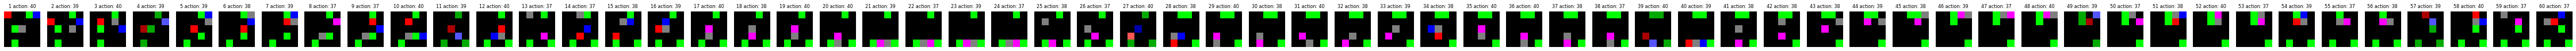

In [23]:
rowToImage('-N2gl9wHXMJoXRg5OyiP')

In [24]:
action_df[len(action_df.columns) + 1] = np.NaN
action_df.tail()

,1,2,3,4,5,6,7,8,9,10,...,52,53,54,55,56,57,58,59,60,61
-N9DuP-A__lF32oAItJX,40,39,38,39,37,40,39,37,40,39,...,40,39,38,38,37,37,40,40,37,NaN
-N9E-5mR0f44kOXaXGX5,39,39,40,40,37,40,40,39,38,39,...,40,38,39,39,38,39,40,39,40,NaN
-N9E0HH4ltbmrAtPrV9n,40,40,39,39,38,37,40,39,39,40,...,39,39,40,40,37,40,37,40,37,NaN
-N9E6o8OJBsSgwkwBxxB,39,39,40,37,37,40,40,40,39,39,...,38,37,37,39,39,39,39,37,38,NaN
-N9FCp-SID9yXh4ve5Jc,40,40,40,38,39,38,37,40,39,39,...,38,39,39,40,40,37,39,40,40,NaN


# Make Dataset

dataset_v1:

In [25]:
# # dir_path = './data/humanModel/dataset_v0.csv'
# # if os.path.exists(dir_path):
# #   os.remove(dir_path)

# # rows = [
# # ["code", "step", "computer_x", "computer_y", "human_x", "human_y", "stag_x", "stag_y", "shrub1_x", "shrub1_y", "shrub2_x", "shrub2_y", "shrub3_x", "shrub3_y", "human_action"] #, "computer_action", "stag_action"]
# # ]
# # counter = 0
# # for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
# #     for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
# #         # check if it is not the last state
# #         # the last state not enter our model, since it is an end state that not contains any dirts and not preform an action
# #         if not np.isnan(action_df.loc[idxRow, idxCol+1]):
# #             row = flatten([[idxRow, idxCol], flatten(state), [int(action)]])
# #             if counter % 500 == 0:
# #                 # print every 500 saved images
# #                 print(row)
# #             counter += 1
# #             rows.append(row)
# #         else:
# #             break
# # print(f'{counter} rows have been saved')
# # np.savetxt(dir_path, 
# #            rows,
# #            delimiter =", ", 
# #            fmt ='% s')

# if path == './data/data-of-baselines-v2-4-stag.json':
#     dir_path = './data/humanModel/dataset'
#     if os.path.exists(dir_path):
#         shutil.rmtree(dir_path)
#     os.mkdir(dir_path)
#     for action in ['37','38','39','40']:
#         os.mkdir(dir_path+'/'+action)

#     # open the file in the write mode
#     f = open(dir_path+'/participants_rate.csv', 'w')
#     # create the csv writer
#     writer = csv.writer(f)

#     counter = 0
#     for (idxRow, s1), (_, s2) in zip(new_state_df.iterrows(), action_df.iterrows()):
#         for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
#             # check if it is not the last state
#             if not np.isnan(action_df.loc[idxRow, idxCol]):
#                 im = Image.fromarray((state * 255).astype(np.uint8))
#                 value_vector_rate = participants_df.loc[idxRow, ['collaborative_value', 'computer_value', 'predictable_value', 'selfishly_value', 'wisely_value']]
#                 path = f'data/humanModel/dataset/{int(action)}/{idxRow}_{idxCol}.png'
#                 if counter % 500 == 0:
#                     # print every 500 saved images
#                     print(f'{idxRow}_{idxCol}.png saved! at action {action}')
#                 counter += 1
#                 im.save(path)

#                 # write a vector to the csv file
#                 writer.writerow(value_vector_rate)
#             else:
#                 break
#     #         print (state, action, idxCol, idxRow)
#     print(f'{counter} images have been saved')

dataset_v2:

In [26]:
def next_position(action, position):
    if action == 32:
        return position
    elif action == 37:
      return [position[0], position[1]-1]
    elif action == 38:
      return [position[0]-1, position[1]]
    elif action == 39:
      return [position[0], position[1]+1]
    elif action == 40:
      return [position[0]+1, position[1]]
    
    raise RuntimeError("Unknown action: " + str(action))

In [27]:
def calc_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def calc_distance_closest_bush(pos1, poses):
    min_dis = calc_distance(pos1, poses[0])
    for i in range(1, len(poses)):
        dis = calc_distance(pos1, poses[i])
        if dis < min_dis:
            min_dis = dis
    return min_dis

def calc_distance_bushes(pos1, poses):
    return np.array([calc_distance(pos1, pos2) for pos2 in poses])

In [28]:
def find_lable(state, action):
    r2, g2, b2 = state[:, :, 0], state[:, :, 1], state[:, :, 2]
    human_pos = np.where((r2 == 1) | (r2 == 1.5))
    human_pos = [human_pos[0][0], human_pos[1][0]]
    bushes_pos = np.where((g2 == 1) | (g2 == 1.5))
    good_bushes_pos = []
    for i in range(3):
        good_bushes_pos.append([bushes_pos[0][i], bushes_pos[1][i]])
    bushes_pos = np.array(good_bushes_pos)    
    stag_pos = np.where(((r2 == 0.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 1.5) & (g2 == 0.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 1.5) & (b2 == 0.5)) |
                        ((r2 == 0.5) & (g2 == 0.5) & (b2 == 1.5)))
    stag_pos = [stag_pos[0][0], stag_pos[1][0]]


    dis_from_stag = calc_distance(human_pos, stag_pos)
    dis_from_bushes = calc_distance_bushes(human_pos, bushes_pos)
    
    next_human_pos = next_position(action, human_pos)
    next_dis_from_stag = calc_distance(next_human_pos, stag_pos)
    next_dis_from_bushes = calc_distance_bushes(next_human_pos, bushes_pos)

    dis = next_dis_from_bushes - dis_from_bushes
    if next_dis_from_stag < dis_from_stag and min(dis) < 0:
        # return "both"
        return "follow_stag"

    if next_dis_from_stag < dis_from_stag:
        return "follow_stag"
        
    if min(dis) < 0:
        return "closest_bush"

    # if next_dis_from_stag < dis_from_stag and next_dis_from_closest_bush < dis_from_closest_bush:
    #     return "both"
    # if next_dis_from_stag > dis_from_stag and next_dis_from_closest_bush > dis_from_closest_bush:
    #     return "none"

    # if next_dis_from_stag < dis_from_stag:
    #     return "follow_stag"
    # if next_dis_from_closest_bush < dis_from_closest_bush:
    #     return "closest_bush"


In [29]:
print(path)
if path == "./data/data-of-baselines-v2-4-stag.json":
    dir_path = './data/humanModel/dataset'
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)
    os.mkdir(dir_path)
    for action in ['follow_stag','closest_bush']:
        os.mkdir(dir_path+'/'+action)

    # open the file in the write mode
    f = open(dir_path+'/participants_rate.csv', 'w')
    # create the csv writer
    writer = csv.writer(f)

    counter = 0
    for (idxRow, s1), (_, s2) in zip(state_df.iterrows(), action_df.iterrows()):
        for (idxCol, state), (_, action) in zip(s1.iteritems(), s2.iteritems()):
            # check if it is not the last state
            if not np.isnan(action_df.loc[idxRow, idxCol]):
                im = Image.fromarray((state * 255).astype(np.uint8))
                value_vector_rate = participants_df.loc[idxRow, ['collaborative_value', 'computer_value', 'predictable_value', 'selfishly_value', 'wisely_value']]
                lable = find_lable(state, action)
                if lable in ['follow_stag','closest_bush']:
                    path = f'data/humanModel/dataset/{lable}/{idxRow}_{idxCol}.png'
                    if counter % 1000 == 0:
                        # print every 500 saved images
                        print(f'{idxRow}_{idxCol}.png saved! at action {lable}')
                    counter += 1
                    im.save(path)

                    # write a vector to the csv file
                    writer.writerow(value_vector_rate)
                
            else:
                break
    #         print (state, action, idxCol, idxRow)
    print(f'{counter} images have been saved')

./data/data-of-baselines-v2-sarl-ddqn-empathy-peccimistic-4-stag.json


# fix scores:

In [30]:
# change the reward of cupturing the stag to 4

# count the number of cupturing the stag



def countCupturedStag(row):
    counter = 0
    # prev_computer_pos =
    # prev_human_pos =
    # prev_stag_pos =
    for i in range(1, len(row)+1):
      if row[i] == None: # game not ended
        break

      cell = row[i]

      computer_action = cell['computerAction']
      human_action = cell['humanAction']
      stag_action = cell['stagAction']

      computer_pos = [cell['stateCoords'][0], cell['stateCoords'][1]]
      human_pos = [cell['stateCoords'][2], cell['stateCoords'][3]]
      stag_pos = [cell['stateCoords'][4], cell['stateCoords'][5]]

      next_computer_pos = next_position(computer_action, computer_pos)
      next_human_pos = next_position(human_action, human_pos)
      next_stag_pos = next_position(stag_action, stag_pos)
      
      # print(row[i])

      # print("next_computer_pos = ", next_computer_pos)
      # print("next_human_pos = ", next_human_pos)
      # print("next_stag_pos = ", next_stag_pos)

      # print(row[i+1])

      # assert 0 <= next_computer_pos[0] < 5 and 0 <= next_computer_pos[1] < 5, 'next_computer_pos must be between 5 and 0: '+ str(next_computer_pos) + "\n" + str(cell)
      # assert 0 <= next_human_pos[0] < 5 and 0 <= next_human_pos[1] < 5, 'next_human_pos must be between 5 and 0: '+ str(next_human_pos) + "\n" + str(cell)
      # assert 0 <= next_stag_pos[0] < 5 and 0 <= next_stag_pos[1] < 5, 'next_stag_pos must be between 5 and 0: '+ str(next_stag_pos) + "\n" + str(cell)

      if next_human_pos == next_stag_pos == next_computer_pos:
        counter += 1

    # raise Exception
    return counter
        
            
def fix_scores(df):
    rewards = {
        'Stag': 4 - 4
    }
    c_h_scores = pd.DataFrame(index=df.index, columns=['computer_score', 'human_score'])
    computer_scores = []
    human_scores = []
    stag_count = []
    for i, row in df.iterrows():
        count_of_cuptured_stag = countCupturedStag(row)

        coputerScore = participants_df.loc[i, 'computer_score'] + count_of_cuptured_stag * rewards['Stag']
        humanScore = participants_df.loc[i, 'human_score'] +  count_of_cuptured_stag * rewards['Stag']
        computer_scores.append(coputerScore)
        human_scores.append(humanScore)
        stag_count.append(count_of_cuptured_stag)

    c_h_scores['computer_score'] = computer_scores
    c_h_scores['human_score'] = human_scores
    c_h_scores['computer_score_real'] = participants_df['computer_score']
    c_h_scores['human_score_real'] = participants_df['human_score']
    c_h_scores['stag_count'] = stag_count
    c_h_scores['behavior'] = participants_df['behavior']
    return c_h_scores

new_scores_df = fix_scores(raw_df_state_to_action)

In [31]:
new_scores_df.groupby('behavior').mean()

,computer_score,human_score,computer_score_real,human_score_real,stag_count
behavior,,,,,
closest,27.075000,23.975000,27.075000,23.975000,0.675000
ddqn,27.846154,29.192308,27.846154,29.192308,3.307692
dropout ddqn,28.250000,32.750000,28.250000,32.750000,3.958333
empathy ddqn,30.043478,23.739130,30.043478,23.739130,0.782609
follow_stag,26.285714,36.833333,26.285714,36.833333,5.857143
random,8.020408,22.306122,8.020408,22.306122,0.591837
sarl ddqn,33.965517,35.310345,33.965517,35.310345,4.724138


### blueScore and redScore for each behavior to exel file to do t-test

In [32]:
to_exel = new_scores_df[['computer_score', 'human_score', 'behavior']]

table_blueScore = pd.DataFrame(index=to_exel.index, columns=to_exel.groupby('behavior').count().index)
for agent in table_blueScore.columns:
    table_blueScore[agent] = to_exel[to_exel['behavior'] == agent]['computer_score']

blueScore_result = pd.concat([table_blueScore[agent].dropna().reset_index().drop('index', axis=1) for agent in table_blueScore.columns], axis=1)

table_redScore = pd.DataFrame(index=to_exel.index, columns=to_exel.groupby('behavior').count().index)
for agent in table_redScore.columns:
    table_redScore[agent] = to_exel[to_exel['behavior'] == agent]['human_score']

redScore_result = pd.concat([table_redScore[agent].dropna().reset_index().drop('index', axis=1) for agent in table_redScore.columns], axis=1)

In [33]:
# with pd.ExcelWriter('./data/agent_scores.xlsx') as writer:
#     blueScore_result.to_excel(writer, sheet_name='blueScore')
#     redScore_result.to_excel(writer, sheet_name='redScore')

In [34]:
# participants_df['computer_score'] = new_scores_df['computer_score']
# participants_df['human_score'] = new_scores_df['human_score']
# participants_df.to_json('new_table.json', orient="index")